In [4]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

from functools import partial

import torch
from datasets import Dataset, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)

from bert_attack_utils import(
    parse_tsv_to_df,
    tokenize_and_align_labels,
    compute_metrics,
    predict_ner_tags,
    get_word_embeddings,
    get_char_table,
    greedy_5char_attack,
    genetic_5char_attack,
    compute_average_metrics,
    evaluate_attacks,
    similarity,
    PGD5CharAttacker
)

In [5]:
MODEL_CHECKPOINT = "emilyalsentzer/Bio_ClinicalBERT"
TRAIN_PATH = "../data/train.tsv"
VAL_PATH = "../data/dev.tsv"
TEST_PATH = "../data/test.tsv"
NUM_EPOCHS = 5
BATCH_SIZE = 16
MAX_LEN = 150
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 1
CLIP_GRAD_NORM = 0.7

In [6]:
"""
Data can be found at Harvard Medical School: https://portal.dbmi.hms.harvard.edu/projects/n2c2-nlp/ 


training, val, test tsv file data looks like this:

Mr. O
Steiner B-PATIENT
is O
scheduled O
today. O
Patient O
has O
not O
been O
seen O
since O
November B-DATE
. O


"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df = parse_tsv_to_df(TRAIN_PATH)
val_df = parse_tsv_to_df(VAL_PATH)
test_df = parse_tsv_to_df(TEST_PATH)


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

all_tags = set()
for df in [train_df, val_df, test_df]:
    for tags in df["ner_tags"]:
        all_tags.update(tags)
all_tags = sorted(list(all_tags))

# Create dictionaries for label -> ID and ID -> label
label2id = {tag: i for i, tag in enumerate(all_tags)}
id2label = {i: tag for tag, i in label2id.items()}

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(all_tags),
    id2label=id2label,
    label2id=label2id
).to(device)

tokenize_fn = partial(tokenize_and_align_labels, tokenizer=tokenizer, label2id=label2id, MAX_LEN=MAX_LEN)
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)



data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


seqeval = load_metric("seqeval")


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",  
    save_strategy="epoch",            
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    logging_dir="./logs",
    logging_steps=100,
    gradient_accumulation_steps=1,  
    max_grad_norm=CLIP_GRAD_NORM,
    load_best_model_at_end=True,      
    metric_for_best_model="f1",
    greater_is_better=True,
)

compute_metrics_fn = partial(compute_metrics, id2label=id2label, seqeval=seqeval)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_fn,
)


trainer.train()

val_metrics = trainer.evaluate()

test_metrics = trainer.evaluate(test_dataset)


predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

pred_tags = []
for i, label_row in enumerate(labels):
    pred_row = predictions[i]
    valid_preds = []
    valid_tokens = []
    for (l_id, p_id, token_id) in zip(label_row, pred_row, test_dataset[i]["input_ids"]):
        if l_id != -100:
            valid_preds.append(id2label[p_id])
    pred_tags.append(valid_preds)



In [8]:
print("Validation Metrics:", val_metrics)
print("Test Metrics:", test_metrics)
print("Example predictions from test set:", pred_tags[0])


Validation Metrics: {'eval_loss': 0.024367349222302437, 'eval_precision': 0.9504950495049505, 'eval_recall': 0.9479921000658328, 'eval_f1': 0.9492419248516809, 'eval_accuracy': 0.9968579460889697, 'eval_runtime': 10.1979, 'eval_samples_per_second': 484.218, 'eval_steps_per_second': 30.3, 'epoch': 5.0}
Test Metrics: {'eval_loss': 0.02091073989868164, 'eval_precision': 0.9394212566483368, 'eval_recall': 0.9394212566483368, 'eval_f1': 0.9394212566483368, 'eval_accuracy': 0.9965194518800938, 'eval_runtime': 203.9356, 'eval_samples_per_second': 159.786, 'eval_steps_per_second': 9.988, 'epoch': 5.0}
Example predictions from test set: ['O', 'O', 'B-DATE']


In [9]:
def get_cyrillic_char_table():
    return {
        'A': 'А',  # Cyrillic capital A
        'a': 'а',  # Cyrillic lowercase a
        'B': 'В',  # Cyrillic capital Ve
        'E': 'Е',  # Cyrillic capital Ye
        'e': 'е',  # Cyrillic small Ye
        'I': 'І',  # Cyrillic capital Byelorussian-Ukrainian I
        'i': 'і',  # Cyrillic small Byelorussian-Ukrainian i
        'K': 'К',  # Cyrillic capital Ka
        'k': 'к',  # Cyrillic small Ka
        'M': 'М',  # Cyrillic capital Em
        'm': 'м',  # Cyrillic small Em
        'H': 'Н',  # Cyrillic capital En
        'O': 'О',  # Cyrillic capital O
        'o': 'о',  # Cyrillic small o
        'P': 'Р',  # Cyrillic capital Er
        'p': 'р',  # Cyrillic small er
        'C': 'С',  # Cyrillic capital Es
        'c': 'с',  # Cyrillic small es
        'T': 'Т',  # Cyrillic capital Te
        't': 'т',  # Cyrillic small te
        'y': 'у',  # Cyrillic small u
        'X': 'Х',  # Cyrillic capital Ha
        'x': 'х',  # Cyrillic small ha
    }

In [10]:
import random

def homoglyph_attack_5chars(text, char_table, model, tokenizer, num_replacements=5):
    text_chars = list(text)
    
    replaceable_indices = [
        i for i, ch in enumerate(text_chars) if ch in char_table
    ]
    

    random.shuffle(replaceable_indices)
    indices_to_replace = replaceable_indices[:num_replacements]
    
    # Perform the replacements
    for idx in indices_to_replace:
        ascii_char = text_chars[idx]
        text_chars[idx] = char_table[ascii_char]
    
    attacked_text = "".join(text_chars)
    orig_emb = get_word_embeddings(model,tokenizer,text)
    new_emb = get_word_embeddings(model, tokenizer, attacked_text)
    sim_val = similarity(orig_emb, new_emb)
    return attacked_text, sim_val

In [ ]:
char_table = get_char_table()
cyrillic_char_table = get_cyrillic_char_table()

original_texts = [
"Dr. Sanders asked Maria to schedule her surgery on March 12, 2025.",
"The clinic informed Michael at 555-987-6543 about his blood test results.",
"Nurse Alexis emailed the patient’s treatment plan to james.clark@hospital.org.",
"Taylor was advised to visit Room 204 at 9:00 AM on 06/15/2024 for a follow-up.",
"Dr. Liu needs to review Lucas’s MRI scan results on April 8th.",
"Ms. Jenkins left a voicemail at 555-222-3333 confirming her next appointment.",
"The hospital asked Christopher to update his insurance details by 07/01/2025.",
"At 2:00 PM on January 4, 2025, Dr. Patel met with Ms. Peterson to discuss lab findings.",
"Please instruct Amanda to email her medical history to patient.records@healthclinic.com.",
"Dr. Gomez recommended that Peter come back for tests every week until July 30, 2025.",
"Caroline’s patient ID is 987654, and she must present it during the check-in process.",
"The cardiologist requested that Mr. Delaney return on 10/31/2025 for a stress test.",
"The nurse reminded Joshua to call 555-111-2222 if he experiences any chest pain.",
"Mrs. Ramirez has an appointment scheduled at 3:15 PM on February 20th with Dr. Vaughn.",
"Please send Tyler’s updated x-ray scans to t.henderson@medcenter.edu.",
"Ms. Nguyen’s biopsy results will be discussed during her phone consultation at 555-654-3210.",
"Dr. Cole instructed Harriet to rest for two weeks following her surgery on 08/25/2025.",
"The dental office informed Mr. James that his cleaning was moved to May 6th at 10:00 AM.",
"Lisa’s recovery plan was emailed to her personal address, lisa.phelps@example.com, by Dr. Fisher.",
"Nurse Torres asked Jonathan to arrive at 8:30 AM on 09/09/2025 for routine bloodwork."

]
total_results = []
similarity_results = defaultdict(list)
for num in range(3):
    for original_text in original_texts:
        attacked_text_greedy, sim_greedy = greedy_5char_attack(
            original_text,
            model,
            tokenizer,
            char_table
        )

        attacked_text_genetic, sim_genetic = genetic_5char_attack(
            original_text,
            model,
            tokenizer,
            char_table,
            pop_size=10,
            generations=5,
            mutation_rate=0.1
        )

        pgd_attacker = PGD5CharAttacker(model, tokenizer, char_table, max_iter=20)
        attacked_text_pgd, sim_pgd = pgd_attacker.attack(original_text)    


        attacked_text_homog, sim_homog = homoglyph_attack_5chars(
            original_text, 
            cyrillic_char_table, 
            model, 
            tokenizer, 
            num_replacements=5)


        attack_texts = {
            "greedy": attacked_text_greedy,
            "genetic": attacked_text_genetic,
            "pgd": attacked_text_pgd,
            "homoglyph": attacked_text_homog
        }

        eval_results = evaluate_attacks(
            original_text=original_text,
            attack_texts=attack_texts,
            model=model,
            tokenizer=tokenizer,
            id2label=id2label
        )
        total_results.append((original_text, eval_results))

        for attack_name, metric_dict in eval_results.items():
            print(f"{attack_name.upper()}")
            for k, v in metric_dict.items():
                print(f"  {k}: {v:.4f}")
            print("-----------------------")
        similarity_results['greedy'].append(sim_greedy)
        similarity_results['genetic'].append(sim_genetic)
        similarity_results['pgd'].append(sim_pgd)
        similarity_results['homoglyph'].append(sim_homog)



In [ ]:
stats_dict = {}
for method, scores in similarity_results.items():
    scores_array = np.array(scores)
    stats_dict[method] = {
        'mean': float(np.mean(scores_array)),
        'std': float(np.std(scores_array)),
    }
print(stats_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
methods = list(stats_dict.keys())
means = [stats_dict[method]['mean'] for method in methods]
stds = [stats_dict[method]['std'] for method in methods]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, means, yerr=stds, capsize=5)

# Customize the plot
plt.title('Comparison of Methods: Mean Scores with Standard Deviation', pad=15)
plt.xlabel('Methods')
plt.ylabel('Score')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Rotate x-labels if needed for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

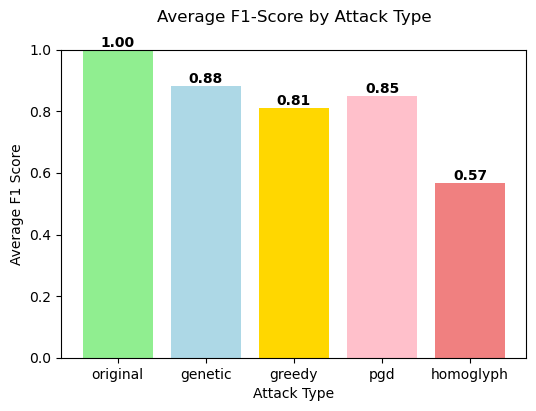

In [8]:
import matplotlib.pyplot as plt

attack_names = ["original", "genetic","greedy", "pgd", "homoglyph"]
avg_metrics = compute_average_metrics(total_results, attack_names=attack_names)

# Extract the F1-scores in order:
f1_scores = [avg_metrics[a]["f1"] for a in attack_names]

plt.figure(figsize=(6, 4))
plt.bar(attack_names, f1_scores, color=["lightgreen", "lightblue", "gold", "pink", "lightcoral"])
plt.title("Average F1-Score by Attack Type", pad=20)
plt.xlabel("Attack Type")
plt.ylabel("Average F1 Score")
plt.ylim([0, 1])  # F1 ranges from 0 to 1
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontweight="bold")
plt.show()

In [9]:
original_preds = predict_ner_tags(
            text=original_texts[0],
            model=model,
            tokenizer=tokenizer,
            id2label=id2label
)
print(original_preds)

[('dr', 'O'), ('.', 'B-DOCTOR'), ('sanders', 'B-DOCTOR'), ('asked', 'O'), ('maria', 'B-DOCTOR'), ('to', 'O'), ('schedule', 'O'), ('her', 'O'), ('surgery', 'O'), ('on', 'O'), ('march', 'B-DATE'), ('12', 'I-DATE'), (',', 'I-DATE'), ('2025', 'I-DATE'), ('.', 'O')]


In [10]:
attacked_text_homog, sim_homog = homoglyph_attack_5chars(
        original_texts[0], 
        cyrillic_char_table, 
        model, 
        tokenizer, 
        num_replacements=5)

attacked_preds = predict_ner_tags(
            text=attacked_text_homog,
            model=model,
            tokenizer=tokenizer,
            id2label=id2label
)
print(attacked_preds)

[('dr', 'O'), ('.', 'B-DOCTOR'), ('sanders', 'B-DOCTOR'), ('asked', 'O'), ('мaria', 'B-DOCTOR'), ('тo', 'I-DOCTOR'), ('sсhеdule', 'I-DOCTOR'), ('her', 'O'), ('surgеry', 'O'), ('on', 'O'), ('march', 'B-DATE'), ('12', 'I-DATE'), (',', 'I-DATE'), ('2025', 'I-DATE'), ('.', 'O')]
